In [1]:
# Model name as saved to gcs (it can be found in the model_name config key in wandb)
# wandb run: feasible-eon-58
MODEL_NAME = "20220529-223515_03_tacotron_8khz_overfit_500_epochs__TacotronTTS"
LOCAL_MODEL_DIR = 'copied_models'

In [2]:
# Access project root dir
import git
import os
root_dir = git.Repo('.', search_parent_directories=True).working_tree_dir

os.chdir(root_dir) # Ugly way to get access to imports but this way is also easier for ginconfig

In [3]:
%load_ext autoreload
%autoreload 2


from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import IPython
import tensorflow as tf
import subprocess

import prepare_data
import training
import cloud_training
import utils
import models
import gin

gin.parse_config_file('config/cloud_gpu.gin')
gin.parse_config_file('config/experiments/03_tacotron_8khz_overfit.gin')
gin.enter_interactive_mode()

fft_length = gin.query_parameter('%fft_length')
frame_length = gin.query_parameter('%frame_length')
frame_step = gin.query_parameter('%frame_step')
sample_rate = gin.query_parameter('%sample_rate')

gsutil = os.path.dirname(gin.query_parameter('gcloud.gcloud_path')) + '/gsutil'
gcs_model_path = gin.query_parameter('gcloud_remote_training.gcs_model_path')

2022-06-01 12:11:07.933404: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-01 12:11:07.933653: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


In [4]:
train_dataset, _ = prepare_data.datasets(target_sample_rate=sample_rate, keep_audio=True, keep_raw_spectrogram=True, keep_transcription=True)

batch = list(train_dataset.take(1))[0]
spectrogram, mel_spec, enc_transcription, audio, raw_spectrogram, transcription = (col[0].numpy() for col in batch)

2022-06-01 12:11:09.147668: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


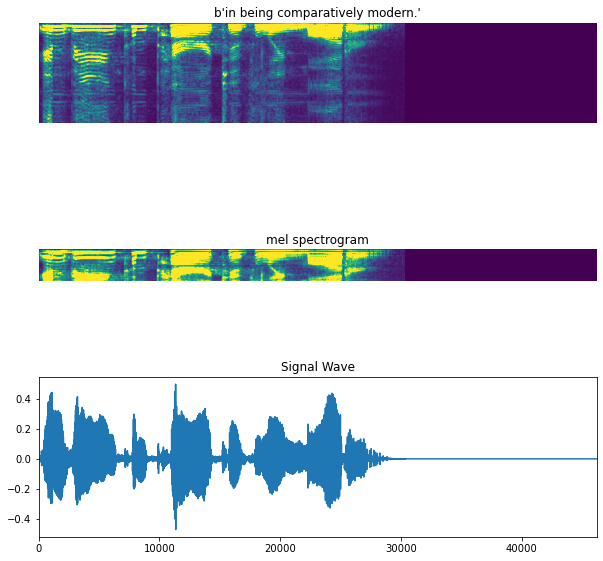

In [5]:
fig = plt.figure(figsize=(10, 10))

ax = plt.subplot(3, 1, 1)
ax.imshow(np.transpose(spectrogram), vmax=1)
ax.set_title(transcription)
ax.axis("off")

ax = plt.subplot(3, 1, 2)
ax.imshow(np.transpose(mel_spec), vmax=1)
ax.set_title('mel spectrogram')
ax.axis("off")

ax = plt.subplot(3, 1, 3)
plt.plot(np.transpose(audio))
ax.set_title("Signal Wave")
ax.set_xlim(0, len(audio))
    
IPython.display.display(IPython.display.Audio(np.transpose(audio), rate=sample_rate))
plt.show()


In [6]:
# Download model and load it
cmd = [gsutil, '-m', 'cp', '-r', gcs_model_path + MODEL_NAME + '*', LOCAL_MODEL_DIR]
res = subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

In [6]:
tts = models.TacotronTTS()
tts.load_weights(LOCAL_MODEL_DIR + '/' + MODEL_NAME + '/final')

# model after first epoch
tts_0 = models.TacotronTTS()
tts_0.load_weights(LOCAL_MODEL_DIR + '/' + MODEL_NAME + '/epoch_0')

In [7]:
GEN_FRAMES = 600

def summarize_mel_stats(mel_spec, new_mel_spec):
    ref_spec = mel_spec[:GEN_FRAMES,:].flatten()
    pred_spec = new_mel_spec[0].numpy().flatten()
    print(f'L1 {np.abs(pred_spec - ref_spec).mean()}')
    return pd.DataFrame({
        'mel_spec': mel_spec[:GEN_FRAMES,:].flatten(),
        'predicted_mel_spec': new_mel_spec[0].numpy().flatten()
    }).describe()

def mel_spec_viz(mel_spec, extra_title=''):
    ax = plt.subplot(2, 1, 1)
    ax.imshow(np.transpose(mel_spec[0]), vmax=1)
    ax.set_title('predicted mel spectrogram' + extra_title)
    ax.axis("off")

    ax = plt.subplot(2, 1, 2)
    ax.imshow(np.transpose(mel_spec[0]))
    ax.set_title('predicted mel spectrogram normalized' + extra_title)
    ax.axis("off")
    plt.show()
    
def encoder_viz(tts, input):
    encoded, _ = tts.tacotron_encoder(input)
    embed = tts.tacotron_encoder.embeddings(input)
    pre_net = tts.tacotron_encoder.pre_net(embed)

    ax = plt.subplot(1, 1, 1)
    ax.imshow(np.transpose(encoded[0]))
    ax.set_title('encoded transcription')
    ax.axis("off")
    plt.show()
    
    ax = plt.subplot(1, 1, 1)
    ax.imshow(np.transpose(embed[0]))
    ax.set_title('embedded transcription')
    ax.axis("off")
    plt.show()
    
    ax = plt.subplot(1, 1, 1)
    ax.imshow(np.transpose(pre_net[0]))
    ax.set_title('pre_net transcription')
    ax.axis("off")

    plt.show()
    
def encoder_viz(tts, input):
    encoded, _ = tts.tacotron_encoder(input)
    mask = input != tf.constant(-1, dtype=tf.int64)
    embed = tts.tacotron_encoder.embeddings(input)
    pre_net = tts.tacotron_encoder.pre_net(embed)
    conv_bank = tts.tacotron_encoder.cbhg.conv_bank(pre_net)
    pooling = tts.tacotron_encoder.cbhg.pooling(conv_bank)
    conv_proj1 = tts.tacotron_encoder.cbhg.conv_proj1(pooling)
    conv_proj2 = tts.tacotron_encoder.cbhg.conv_proj2(conv_proj1)
    pre_rnn = pre_net + conv_proj2
    rnn = tts.tacotron_encoder.cbhg.rnn_encoder(pre_rnn, mask=mask)

    plt.figure(figsize=(14, 8))
    
    data_sets = [
        encoded, embed, pre_net, conv_bank, pooling,
        conv_proj1, conv_proj2, pre_rnn, rnn
    ]
    captions = [
        'encoded', 'embedded', 'pre_net', 'conv_bank', 'pooling',
        'conv_proj1', 'conv_proj2', 'pre_rnn', 'rnn'
    ]
    
    for ix, (caption, data) in enumerate(zip(captions, data_sets)):
        ax = plt.subplot(1, len(data_sets), ix+1)
        ax.imshow(np.transpose(data[0]))
        ax.set_title(caption)
        ax.axis("off")
        
    plt.show()

In [8]:
# Generate mel_specs

input = tf.expand_dims(enc_transcription[enc_transcription!=-1], 0)
new_mel_spec = tts.decode(input, GEN_FRAMES)
new_mel_spec_0 = tts_0.decode(input, GEN_FRAMES)

In [9]:
summarize_mel_stats(mel_spec, new_mel_spec)

L1 0.5011895298957825


,mel_spec,predicted_mel_spec
count,24000.000000,24000.000000
mean,0.516777,0.598893
std,0.527056,0.431719
min,0.000000,0.000000
25%,0.098989,0.264754
50%,0.375960,0.545452
75%,0.765602,0.737852
max,3.915968,2.156746


In [10]:
summarize_mel_stats(mel_spec, new_mel_spec_0)

L1 0.478580117225647


,mel_spec,predicted_mel_spec
count,24000.000000,24000.000000
mean,0.516777,0.075977
std,0.527056,0.084528
min,0.000000,0.000000
25%,0.098989,0.000000
50%,0.375960,0.028116
75%,0.765602,0.150524
max,3.915968,0.253740


In [11]:
mel_spec.shape

(718, 40)

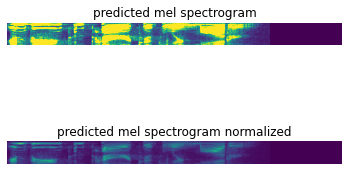

In [12]:
mel_spec_viz([mel_spec[:GEN_FRAMES,:]])

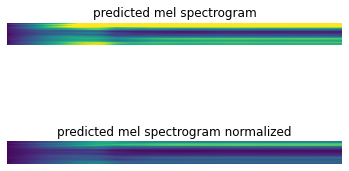

In [13]:
mel_spec_viz(new_mel_spec)

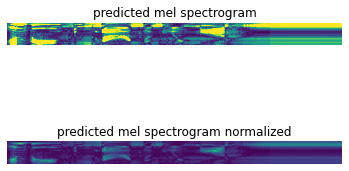

0.50118953


In [14]:
diff = np.abs(mel_spec[:GEN_FRAMES,:]-new_mel_spec[0])
mel_spec_viz([diff])
print(diff.mean())

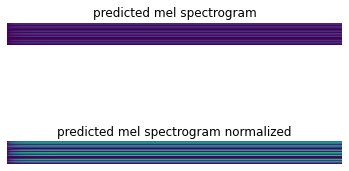

In [15]:
mel_spec_viz(new_mel_spec_0)

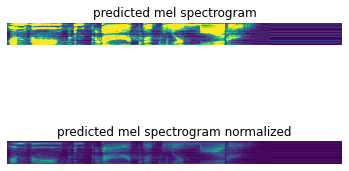

0.47858012


In [16]:
diff = np.abs(mel_spec[:GEN_FRAMES,:]-new_mel_spec_0[0])
mel_spec_viz([diff])
print(diff.mean())

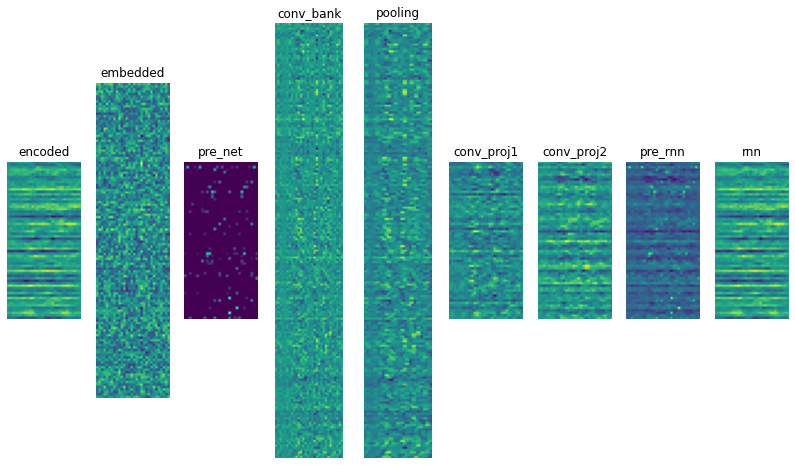

In [17]:
encoder_viz(tts, input)

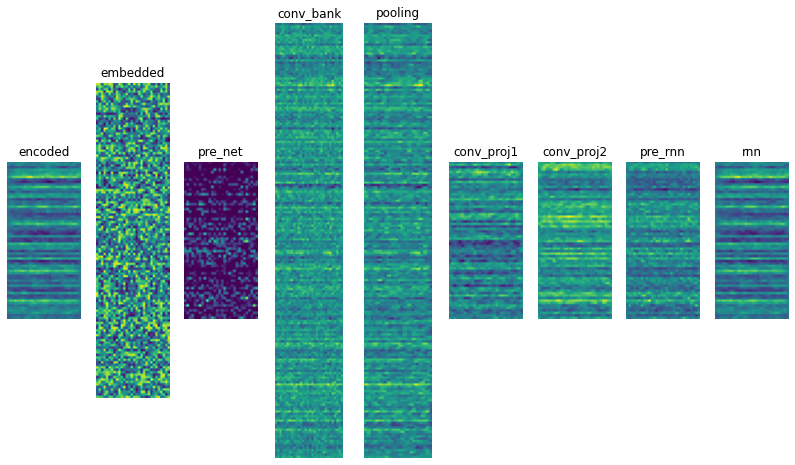

In [18]:
encoder_viz(tts_0, input)

In [19]:
def visualize_attention_states(att_rnn_states):
    data = tf.concat([s[0] for s in att_rnn_states], 0)

    plt.figure(figsize=(10, 8))

    ax = plt.subplot(1, 1, 1)
    ax.imshow(np.transpose(data[:,:]))
    ax.set_title('cell states')
    ax.axis("off")
    plt.show()
    
    data = tf.concat([s[1] for s in att_rnn_states], 0)

    plt.figure(figsize=(10, 8))

    ax = plt.subplot(1, 1, 1)
    ax.imshow(np.transpose(data[:,:]))
    ax.set_title('attention')
    ax.axis("off")
    plt.show()
    
    data = tf.concat([s[2] for s in att_rnn_states], 0)

    plt.figure(figsize=(16, 14))

    ax = plt.subplot(1, 1, 1)
    ax.imshow(np.transpose(data[:,:]))
    ax.set_title('attention state (alignments)')
    ax.axis("off")
    plt.show()

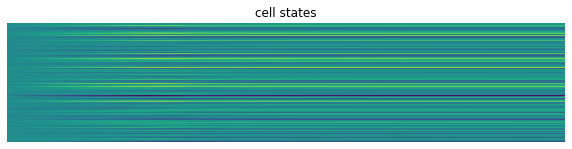

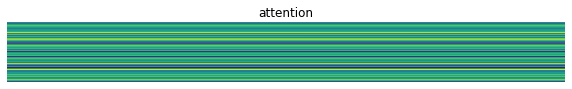

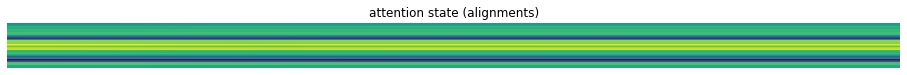

In [20]:
# TRAINED TTS
_, states = tts.decode(input, GEN_FRAMES, return_states=True)
att_rnn_states = [s[0] for s in states]
visualize_attention_states(att_rnn_states)

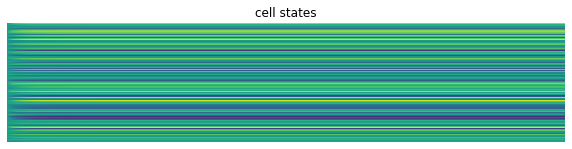

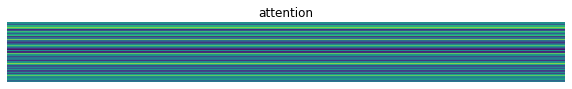

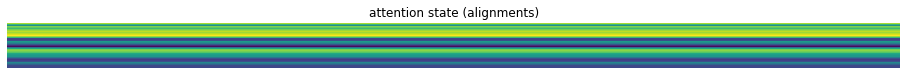

In [21]:
# TRAINED TTS epoch 0
_, states = tts_0.decode(input, GEN_FRAMES, return_states=True)
att_rnn_states = [s[0] for s in states]
visualize_attention_states(att_rnn_states)

# Compare generated mel spectrogram to what is generated in training

In [22]:
tr_mel_spec, tr_enc_transcription = batch[1:3] # Get the relevant columns
tr_inp_mel_spec = tf.pad(tr_mel_spec[:, :-1,:], [(0, 0), (1,0), (0,0)]) # Add the go frame to input spectrogram

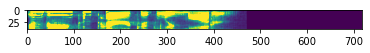

In [23]:
out = tts([tr_enc_transcription[:1], tr_mel_spec[:1]])
plt.imshow(np.transpose(out[0]), vmax=1)

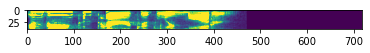

In [24]:
plt.imshow(np.transpose(tr_mel_spec[0]), vmax=1)

In [25]:
np.abs(out[0]-tr_mel_spec[0]).mean()

0.0318563

The model has generated a decent looking mel spectrogram, also the L1 loss looks pretty decent. It's a clear improvement over the epoch 0 model:

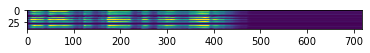

In [26]:
out_0 = tts_0([tr_enc_transcription[0:1], tr_mel_spec[:1]])
plt.imshow(np.transpose(out_0[0]), vmax=1)

In [27]:
np.abs(out_0[0]-tr_mel_spec[0]).mean()

0.34491935

Now, the model is not using the input transcription, as you can see below

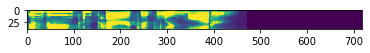

In [28]:
out = tts([tf.constant([[2,3,4,5,6,-1,-1]], dtype=tf.int64), tr_mel_spec[:1]])
plt.imshow(np.transpose(out[0]), vmax=1)

Well, not completely true, we actually see different mel spectrograms being generated when different input transcriptions are used.

Well, at least we know the model has capacity to generate the mel-spectrogram ;).

# Inspecting gradients for epoch 0 model

In [29]:
mae = tf.keras.losses.MeanAbsoluteError()

with tf.GradientTape() as tape:
    out = tts_0([tr_enc_transcription[:1], tr_mel_spec[:1]])
    loss = mae(out[0], tr_mel_spec[0])

variables = tts_0.trainable_variables
gradients = tape.gradient(loss, variables)

In [30]:
# Variables we are most interested in, memory related:
for gradient, variable in zip (gradients, variables):
    if 'BahdanauAttention' in variable.name:
        print('Variable: ', variable.name)
        print('Gradient: ', gradient)

Variable:  tacotron_mel_decoder_1/rnn_1/attention_concatenator_wrapper_1/BahdanauAttention/attention_v:0
Gradient:  tf.Tensor(
[ 0.06694064 -0.04737634 -0.04946553  0.03761381 -0.03183274 -0.10110758
 -0.04386332  0.03090633 -0.04496378 -0.068802    0.0047358   0.01366165
 -0.02769402  0.04065305 -0.08104873 -0.06434819 -0.1456077   0.04251739
 -0.04274167  0.01727718  0.03001793 -0.05046062 -0.0068365   0.02381229
  0.03261502  0.0683991  -0.00387598 -0.02101518 -0.06479099  0.10009769
  0.02654712  0.06806176  0.03732036  0.08154429  0.04759097 -0.07261917
 -0.08014317 -0.01862993  0.08458316  0.10334567 -0.0690894  -0.02005082
  0.04977501 -0.01729549  0.01324122 -0.00423588  0.02698736 -0.04773873
 -0.00267694  0.11757959 -0.01579633  0.03938792  0.00273078  0.0487945
  0.03212209  0.01933478 -0.0934603   0.05348944  0.06836729  0.05567725
 -0.0238284  -0.11249633 -0.0143771  -0.07574172  0.09611251  0.20204723
  0.03155461 -0.01763    -0.02784834  0.06518181  0.03215652  0.0725313

In the above we see the gradients that result from training on the original mel spectrogram as input. (As it is done in training).

These are the gradients flowing from the weighting part of the attention. The first matrix corresponds to the vector V that is used as a dot product to generate the score that subsequently is fed to Softmax. We can see that these gradients are larger than the gradients used to update the the matrix for the query (the RNN cell output) and matrix for keys/memory (the encoder output). Why is the query matrix gradients smaller? Mmmh, maybe the query activations are relatively larger than the key activations? Or perhaps the error generated by the memory is more important than the query for the current parameters? It would be interesting to see the gradients for the transformed key and transformed query.

First let's try to see what attention looks like for the original mel spectrogram.

# Attention during training

In [31]:
def decode(model, encoder_inputs, input_mel, return_states=None):
    encoded_inputs, seq_lengths = model.tacotron_encoder(encoder_inputs)
    state = None
    model.tacotron_mel_decoder.setup_attended(encoded_inputs, seq_lengths)

    output = []
    states = []
    
    num_frames = tf.shape(input_mel)[1]

    for i in range(num_frames):
        input_frame = input_mel[:, i:i+1, :]
        new_output, state = model.tacotron_mel_decoder(input_frame, state)
        if return_states:
            states.append(state)
        output.append(new_output)

    mel_spec = tf.concat(output, axis=1)

    if return_states:
        return [mel_spec, states]
    else:
        return mel_spec



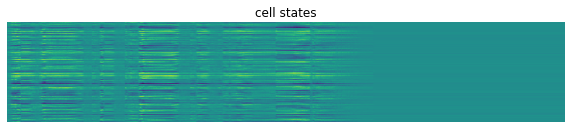

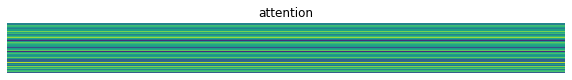

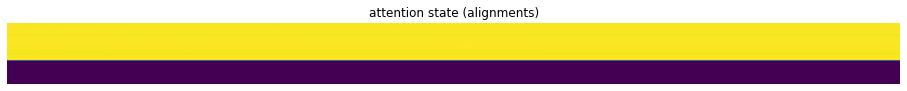

In [32]:
# TRAINED TTS
_, states = decode(tts, tr_enc_transcription[:1], tr_mel_spec[:1], return_states=True)
att_rnn_states = [s[0] for s in states]
visualize_attention_states(att_rnn_states)

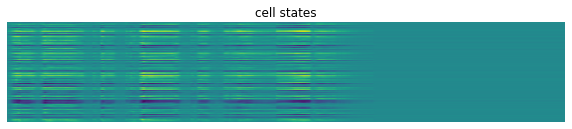

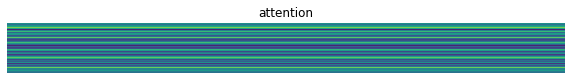

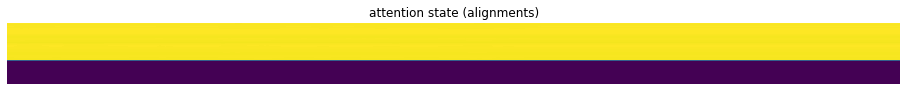

In [34]:
# Epoch 0
_, states = decode(tts_0, tr_enc_transcription[:1], tr_mel_spec[:1], return_states=True)
att_rnn_states = [s[0] for s in states]
visualize_attention_states(att_rnn_states)

In [35]:
# Alignment
tf.concat([s[2] for s in att_rnn_states], 0)

<tf.Tensor: shape=(718, 49), dtype=float32, numpy=
array([[0.03353456, 0.03328792, 0.03351015, ..., 0.        , 0.        ,
        0.        ],
       [0.03353549, 0.03328879, 0.03350984, ..., 0.        , 0.        ,
        0.        ],
       [0.03353518, 0.03328852, 0.03350843, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.03353374, 0.03328734, 0.03350988, ..., 0.        , 0.        ,
        0.        ],
       [0.03353374, 0.03328734, 0.03350989, ..., 0.        , 0.        ,
        0.        ],
       [0.03353374, 0.03328734, 0.03350988, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)>

I'm worried that alignment plays such a little role in the training. Is this an optimization problem? Or it is just because of the overfitting setup (no complex encoder information is needed to overfit a few samples).

Even a random model shows this pattern.

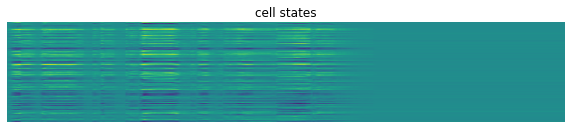

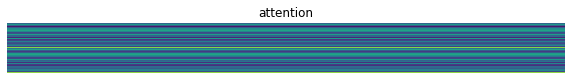

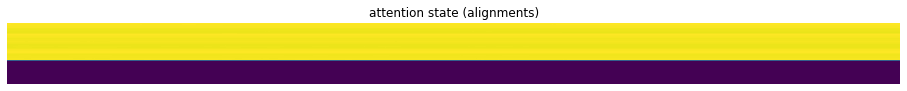

In [107]:
# Random model
random_tts = models.TacotronTTS()
_, states = decode(random_tts, tr_enc_transcription[:1], tr_mel_spec[:1], return_states=True)
att_rnn_states = [s[0] for s in states]
visualize_attention_states(att_rnn_states)

In [108]:
memory_layer = random_tts.tacotron_mel_decoder.attention_mechanism.memory_layer
W = memory_layer.get_weights()

In [115]:
memory_layer.set_weights([w * 2 for w in W])

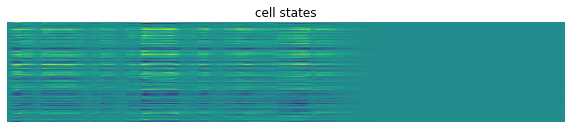

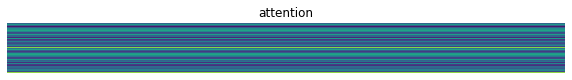

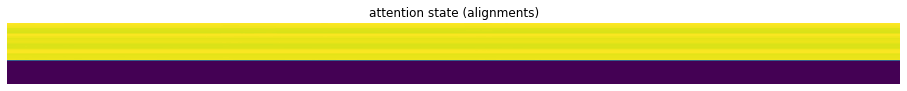

In [116]:
_, states = decode(random_tts, tr_enc_transcription[:1], tr_mel_spec[:1], return_states=True)
att_rnn_states = [s[0] for s in states]
visualize_attention_states(att_rnn_states)

In the experiment above if I increase the weights for memory you see a stronger banded pattern in attention because memory/keys influences attention more. If you do the opposite, all inputs get equal weight because the same number ends up being calculated for each input.

# Quick and dirty check of attention calculation (Ugly)

In [186]:
def decode_inlined(model, encoder_inputs, input_mel):
    encoded_inputs, seq_lengths = model.tacotron_encoder(encoder_inputs)
    state = None
    model.tacotron_mel_decoder.setup_attended(encoded_inputs, seq_lengths)

    input_frame = tf.zeros((tf.shape(encoder_inputs)[0], 1, model.mel_bins))
    input_frame_cell = tf.zeros((tf.shape(encoder_inputs)[0], model.mel_bins))

    
    output = []
    states = []
    
    # Only batch dimension matters
    state = model.tacotron_mel_decoder.rnn_cell.get_initial_state(input_frame_cell)
    state_d1 = model.tacotron_mel_decoder.decode_rnn1.get_initial_state(input_frame)
    state_d2 = model.tacotron_mel_decoder.decode_rnn2.get_initial_state(input_frame)

    num_frames = tf.shape(input_mel)[1]
    
    mae = tf.keras.losses.MeanAbsoluteError()
    loss = tf.constant(0.0)
    queries = []
    rep_queries = []
    keys = []
    t_interactions = []
    attentions = []
    t_alignments = []

    with tf.GradientTape() as tape:

    
      for i in range(num_frames-1):
        
        states.append(state)
        
        inp = input_mel[:, i, :]
        
        inp = model.tacotron_mel_decoder.pre_net(inp)
        inp = model.tacotron_mel_decoder.rnn_cell._cell_input_fn(inp, state.attention)
        outp, new_cell_state = model.tacotron_mel_decoder.rnn_cell._cell(inp, state.cell_state)
        
        hack_keys = model.tacotron_mel_decoder.attention_mechanism.keys + tf.constant(0.0)
        tape.watch(hack_keys)
        keys.append(hack_keys)

        processed_query = model.tacotron_mel_decoder.attention_mechanism.query_layer(outp)
        processed_query = tf.expand_dims(processed_query, 1)
        queries.append(processed_query)
        processed_query = tf.repeat(processed_query, [hack_keys.shape[1]], axis=1)
        rep_queries.append(processed_query)
        #print(tf.norm(processed_query, axis=2))
        #print(tf.norm(model.tacotron_mel_decoder.attention_mechanism.keys, axis=2))
        
        interactions = hack_keys + processed_query
        t_interactions.append(interactions)
        interactions = tf.tanh(interactions)
        
        score = tf.reduce_sum(
            model.tacotron_mel_decoder.attention_mechanism.attention_v * interactions, [2]
        )
        alignments = model.tacotron_mel_decoder.attention_mechanism.probability_fn(score, state.attention_state)
        t_alignments.append(alignments)
        next_attention_state = alignments
        
        expanded_alignments = tf.expand_dims(alignments, 1)
        context_ = tf.matmul(expanded_alignments, model.tacotron_mel_decoder.attention_mechanism.values)
        attention = tf.squeeze(context_, [1])
        attentions.append(attention)

        outp = tf.concat([outp, attention], -1)
        outp = model.tacotron_mel_decoder.proj_attention(outp)
        state = state.clone(
            attention=attention, alignments=alignments,
            attention_state=next_attention_state, cell_state=new_cell_state
        )
        x = tf.expand_dims(outp,1)
        x1, state_d1 = model.tacotron_mel_decoder.decode_rnn1(x, initial_state=state_d1)
        x2, state_d2 = model.tacotron_mel_decoder.decode_rnn2(x+x1, initial_state=state_d2)
        x = model.tacotron_mel_decoder.proj(x+x1+x2)
        
        output.append(x)
        
        loss += mae(x, input_mel[:, i+1, :])
        
    gradients = tape.gradient(loss, {
        'interactions': t_interactions, 
        'keys': keys, 
        'rep_queries': rep_queries,
        'queries': queries,
        'attentions': attentions,
        'alignments': t_alignments,
    })

    return states, gradients

In [134]:
random_tts = models.TacotronTTS()
_ = decode(random_tts, tr_enc_transcription[:1], tr_mel_spec[:1][:2], return_states=True) # Just to create weights

In [187]:
states, gradients = decode_inlined(random_tts, tr_enc_transcription[:1], tr_mel_spec[:1, :5])

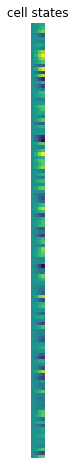

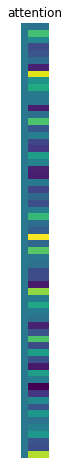

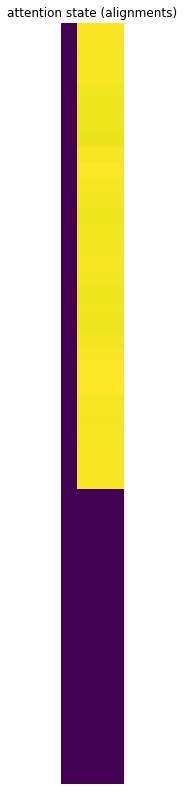

In [179]:
att_rnn_states = states
visualize_attention_states(att_rnn_states)

What I noticed is that the gradients going down the keys/memory path are larger than the ones
going to the queries path. The reason for this is that in order to sum processed queries to
processed keys, one needs to broadcast queries for all input tokens. This is done through
expanding dimensions and then broadcasting. In the code above I used repeat in order to
capture the gradient going to the queries before they are summed. As it turns out the sum
causes the gradients to become very small I also show in the cell below that an example of
key gradients to compare their relative magnitude.

I don't know if this small rate of updates to query path is a big problem. Maybe it is overcome
eventually in learning.

In [180]:
gradients['rep_queries'][0][0, :, :5].numpy().sum(axis=0), gradients['queries'][0][0][0, :5]

(array([-1.5652404e-09, -6.1118044e-10,  1.5497790e-08,  2.3801476e-09,
         2.7147507e-08], dtype=float32),
 <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([-1.5647856e-09, -6.1072569e-10,  1.5494152e-08,  2.3796929e-09,
         2.7150236e-08], dtype=float32)>)

In [181]:
gradients['keys'][0], gradients['queries'][0]

(<tf.Tensor: shape=(1, 49, 128), dtype=float32, numpy=
 array([[[ 6.1987557e-06, -3.9515853e-06, -1.6693171e-05, ...,
           4.0143586e-06, -9.8137771e-06,  1.0150970e-05],
         [ 6.1810224e-06, -3.9392362e-06, -1.6643229e-05, ...,
           4.0031841e-06, -9.7841312e-06,  1.0107710e-05],
         [ 2.1799265e-06, -1.3894174e-06, -5.8700030e-06, ...,
           1.4117171e-06, -3.4508384e-06,  3.5689588e-06],
         ...,
         [ 0.0000000e+00, -0.0000000e+00, -0.0000000e+00, ...,
           0.0000000e+00, -0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00, -0.0000000e+00, -0.0000000e+00, ...,
           0.0000000e+00, -0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00, -0.0000000e+00, -0.0000000e+00, ...,
           0.0000000e+00, -0.0000000e+00,  0.0000000e+00]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1, 128), dtype=float32, numpy=
 array([[[-1.56478563e-09, -6.10725692e-10,  1.54941517e-08,
           2.37969289e-09,  2.71502358e-08,  1.48666004e-08,
    

In [185]:
gradients['attentions'][0]

<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[-4.5388490e-02, -7.8493962e-04, -2.5333202e-02, -1.3268556e-02,
         1.6821837e-02, -2.6121937e-02, -4.5141935e-02,  4.3002404e-02,
        -1.8817339e-02, -2.3789931e-02,  4.4173505e-03,  1.7391663e-02,
         2.0132057e-02, -3.0778170e-02, -2.8361127e-02,  3.7182756e-02,
        -2.3028150e-02,  2.4783177e-02,  7.3500555e-03,  1.6062520e-03,
        -4.4849347e-03, -1.8327996e-02, -6.3440977e-03,  3.1400044e-03,
         2.3958627e-03,  1.2405634e-02, -1.0056236e-02, -4.8846457e-02,
        -3.3344988e-02, -8.4086712e-03, -2.4222899e-02, -9.7034778e-03,
         2.2863347e-02, -3.8698807e-02,  5.8402866e-03, -7.7209108e-02,
        -2.2309963e-02,  2.8653916e-02, -1.2900574e-02,  3.5119083e-02,
        -1.2991661e-02, -1.4606485e-02, -1.3376128e-02,  2.1798294e-03,
         3.0558493e-02,  2.5841789e-02, -1.1509534e-02,  2.7217843e-02,
        -2.6242172e-02,  3.4146793e-02,  1.4048948e-02,  2.2038514e-02,
        -3.6194

In [188]:
gradients['alignments'][0]

<tf.Tensor: shape=(1, 49), dtype=float32, numpy=
array([[-8.2831091e-04, -8.3301199e-04, -2.9675798e-03, -2.5941380e-03,
        -5.8534234e-03, -4.3053553e-03, -2.6588212e-03, -4.7457423e-03,
        -5.4528699e-03, -4.2859274e-03, -3.1941547e-03, -4.5740614e-03,
        -5.7950383e-03, -7.7237701e-03, -7.5638285e-03, -6.9786343e-03,
        -5.9490716e-03, -5.0091911e-03, -7.2022341e-03, -7.3729269e-03,
        -5.4024477e-03, -4.5143929e-03, -3.2335664e-03, -3.9027962e-03,
         8.9596026e-05, -2.3842528e-03, -5.6675030e-03, -2.9488187e-03,
        -5.8060139e-04,  1.1814013e-04,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00]], dtype=float32)>

Now that we can see that with overfitting we are able to reconstruct the MEL spectrogram,
we will use the entire dataset (that is less or equal than 4 seconds) and see if the need
for attention will increase and we start seeing interesting alignments.

The analysis here suggests that scheduled sampling is needed to generate reasonable
mel spectrograms. According to the tacotron paper the CBHG module makes that unnecessary.
So we will still need to add highway networks and increase the number of filters.

Something also important is to generate multiple samples per step.